In my cursory analysis earlier I found that small mass halos had more central galaxies than is expected. I'm going to more explicitly test this. 

In [111]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
colors = sns.color_palette()

In [112]:
from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
from halotools.empirical_models import NFWPhaseSpace, Zheng07Sats
from halotools.sim_manager import CachedHaloCatalog

My implementation of the RegMagic HOD as a subclass of the Zheng07 HOD. 

In [113]:
class RedMagicCens(Zheng07Cens):
    """Slight tweak of the Zheng model to add a new parameter, f_c
    """
    #TODO what meaning does Luminosity threshold hold here?
    def __init__(self,**kwargs):
        
        upper_occupation_bound = 1.0
        super(RedMagicCens,self).__init__(**kwargs)
        
        if 'f_c' not in self.param_dict:
            self.param_dict['f_c'] = 0.19 #add in best fit of new param.
        
    def mean_occupation(self, **kwargs):
        "See Zheng07 for details"
        return self.param_dict['f_c']*super(RedMagicCens,self).mean_occupation(**kwargs)
    
class RedMagicSats(Zheng07Sats):
    "Slight tweak of Zheng model to add new parameter, f_c"
    
    def __init__(self, **kwargs):
        
        upper_occupation_bound = float("inf")
        super(RedMagicSats,self).__init__(**kwargs)
        
        #TODO not sure if this will work for the whole model; will need to test
        #may need to 'modulate'
        #if 'f_c' not in self.param_dict:
        #    self.param_dict['f_c'] = 0.19 #add in best fit of new param.
        
    def mean_occupation(self, **kwargs):
        "See Zheng07 for details"
        f_c = 1
        if 'f_c' in self.param_dict:
            f_c = self.param_dict['f_c']
        
        return super(RedMagicSats,self).mean_occupation(**kwargs)/f_c

In [114]:
rz = 0.0
cens_prof_model = TrivialPhaseSpace(redshift = rz)
sats_prof_model = NFWPhaseSpace(redshift = rz)
model_instance = HodModelFactory(
        #centrals_occupation = RedMagicCens(redshift = rz),
        centrals_occupation = Zheng07Cens(redshift = rz),
        centrals_profile = cens_prof_model,
        #satellites_occupation = RedMagicSats(redshift = rz),
        satellites_occupation = Zheng07Sats(redshift = rz),
        satellites_profile = sats_prof_model)

Load the relevant multidark sim and populate the model.

In [115]:
simname = 'bolshoi'
version_name = 'most_recent'
halocat= CachedHaloCatalog(simname = simname, halo_finder = 'rockstar', redshift = rz)

In [116]:
model_instance.populate_mock(halocat)#, Num_ptcl_requirement = 0)

Calculate average number of Centrals and Satellites

In [117]:
from halotools.mock_observables import return_xyz_formatted_array
from halotools.utils import group_member_generator

halos = model_instance.mock.halo_table

halos.sort(['halo_id', 'halo_upid'])
grouping_key = 'halo_id'
requested_columns = ['halo_num_centrals', 'halo_num_satellites', 'halo_mvir']
group_gen = group_member_generator(halos, grouping_key, requested_columns)

ncen = []
nsat = []
mass = []

for first, last, member_props in group_gen:

    ncen.append(member_props[0][0])
    nsat.append(member_props[1][0])
    mass.append(member_props[2][0]) 
    
ncen = np.array(ncen)
nsat = np.array(nsat)
mass = np.array(mass)

In [118]:
from halotools.mock_observables import mean_y_vs_x
xmin, xmax = 1e11, 1e16
ymin, ymax = 0, 70
halo_mass = np.logspace(np.log10(xmin),np.log10(xmax),100) #bad name, actually mass bins. 

binned_logmass, ncen_hat, ncen_err= mean_y_vs_x(mass, ncen, bins = halo_mass, error_estimator = 'variance')
binned_logmass, nsat_hat, nsat_err= mean_y_vs_x(mass, nsat, bins = halo_mass, error_estimator = 'variance')

nhalo_binned, be = np.histogram(mass, halo_mass)

0.737595659218


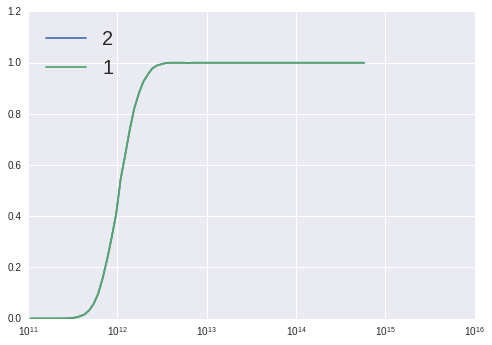

In [119]:
from scipy.stats import binned_statistic
ncen_hat_2,be, bn = binned_statistic(mass, ncen, bins = halo_mass)
print np.nanmean(ncen_hat)
plt.plot( (be[:-1]+be[1:])/2, ncen_hat_2, label = '2')
plt.plot( (be[:-1]+be[1:])/2, ncen_hat, label = '1')
plt.xscale('log')
plt.xlim([xmin,xmax])
plt.ylim([0, 1.2])
plt.legend(loc = 'best', fontsize = 20)
plt.show()

In [120]:
mean_ncen = model_instance.mean_occupation_centrals(prim_haloprop = halo_mass)
mean_nsat = model_instance.mean_occupation_satellites(prim_haloprop = halo_mass)

In [134]:
size = (250.0)**3

data[simname] = (mass, ncen, nsat, size)

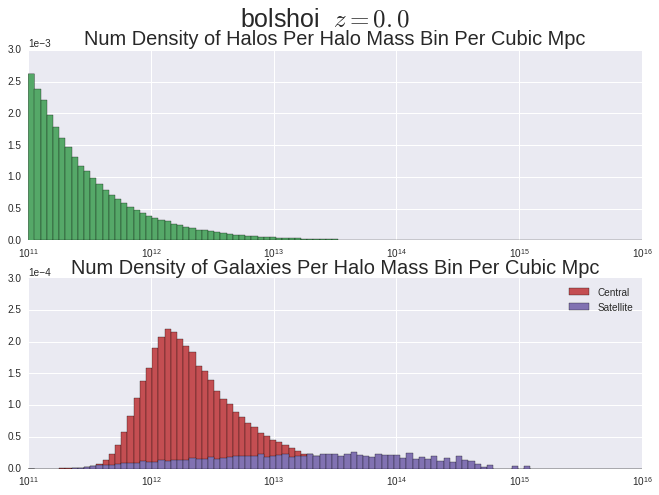

In [135]:
-

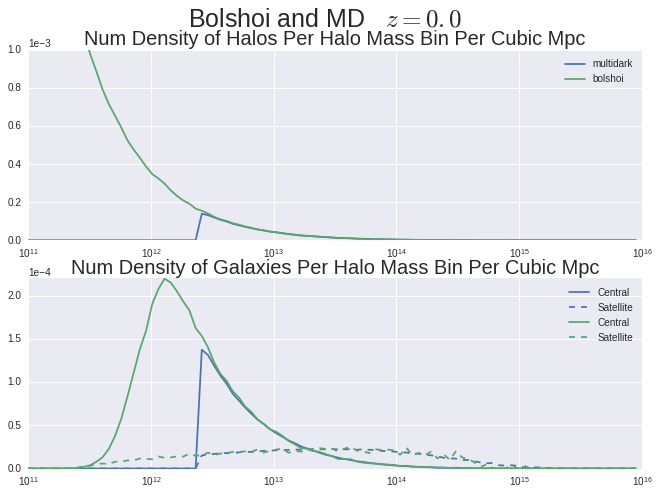

In [139]:
-